Copyright 2024 Zhixuan Hu

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os, re, sys, json, time, random, types
import torch
import torch.nn as nn               # 用于继承的模型都在这里
import torch.nn.functional as F     # 常用的激活函数、损失函数等
from torchsummary import summary    # 用于模型总结
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

os.chdir('./')                      # 设定工作根目录
sys.path.append(os.path.join(os.getcwd(), '../../'))
from Scripts.arkDLtools.dltools import select_device, Controller, Marker
from torch.utils.collect_env import get_pretty_env_info
env_info = get_pretty_env_info()    # 获取硬件、操作系统、pytorch版本等env信息
device, device_name = select_device()   # device是对象，device_name是设备名称

Intel(R) Arc(TM) Graphics selected.


In [2]:
import pandas as pd

### 定义评价指标和验证函数

In [3]:
def metrics(outputs, labels): 
    outputs, labels = outputs.cpu(), labels.cpu().numpy()                            # 定义评价指标（准确率）
    preds = torch.where(outputs > 0.5, torch.tensor(1, dtype=torch.int8), torch.tensor(0, dtype=torch.int8))   # 获取预测类别
    preds = preds.numpy()
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return accuracy, precision, recall, f1  # 计算准确率

# 模型验证
def validate(model, Loss=F.cross_entropy, Metrics=metrics, val_loader=None):
    model.eval()                            # 模型切换到推理模式，否则会自动计算梯度，更新参数
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = 0, 0, 0, 0, 0                          # 初始化损失

    for inputs, labels in val_loader:       # 迭代一批次的验证集数据
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)             # 计算模型输出
        loss = Loss(outputs, labels)        # 计算损失函数
        val_loss += loss.item()             # item方法提取出tensor中的数字
        accuracy, precision, recall, f1 = Metrics(outputs, labels)    # 计算评价指标
        val_accuracy += accuracy
        val_precision += precision
        val_recall += recall
        val_f1 += f1
    val_loss /= len(val_loader)             # 计算平均损失
    val_accuracy /= len(val_loader)           # 计算评价指标平均值
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_f1 /= len(val_loader)
    return val_loss, val_accuracy, val_precision, val_recall, val_f1

### 定义训练函数

In [4]:
import time

def train(device, marker, controller, model, optimizer, Loss=F.cross_entropy, Metrics=metrics,  
          train_loader=None, val_loader=None, epochs=10):   # 模型、优化器、损失函数、评价准则、数据数据生成器、批次等超参数可调
    
    end = marker.begin_time     # 记录开始时间点
    model.train()               # 切换模型到训练模式
    controller.run(controller.oprs('stdSTART'))

    for epoch in range(epochs):                     # 迭代epoch批次
        train_loss = 0; train_metric = 0            # 初始化损失和评价指标
        main_begin = time.time()                # 记录训练过程开始的时间点
        pre_time = main_begin - end             # 计算本epoch训练前操作耗时
        for inputs, labels in train_loader:     # 迭代batch中的每个样本
            inputs, labels = inputs.to(device), labels.to(device)    # 将tensor切换到GPU存储模式
            optimizer.zero_grad()               # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）
            outputs = model(inputs)             # 计算模型输出
            loss = Loss(outputs, labels)        # 计算损失函数
            train_loss += loss.item()           # item方法提取出tensor中的数字
            loss.backward()                     # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()                    # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        main_end = time.time()                  # 记录训练过程结束的时间点
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, Loss, Metrics, val_loader)    # 模型验证
        end = time.time()                       # 记录epoch结束的时间点

        mark_value=dict(pre_time=pre_time, train_time=main_end - main_begin, aft_time=end - main_end,
                        train_loss=train_loss / len(train_loader), val_loss=val_loss, accuracy=val_accuracy, 
                        precision=val_precision, recall=val_recall, f1_score=val_f1)
        state_dict=dict(model_state_dict=model.state_dict(), optim_state_dict=optimizer.state_dict())

        oprs = controller.oprs('stdIO', mark_value=mark_value, state_dict=state_dict)

        if epoch < epochs-2:
            controller.run(oprs)
        else:
            controller.run([oprs])

### 构建数据读取与生成器

In [5]:
pattern = re.compile(r".*\.csv")
data_path = '../../dataset/'
files = os.listdir(data_path)
files = [file for file in files if pattern.match(file)]
files

['chatgpt_HC3_all.csv',
 'gpt_0125_00.csv',
 'human_00.csv',
 'human_01_01.csv',
 'human_01_02.csv',
 'human_02.csv',
 'human_cook_01.csv',
 'human_cook_02.csv',
 'human_HC3_all.csv',
 'human_modern_01.csv',
 'human_modern_02.csv',
 'human_travel_01.csv',
 'human_travel_02.csv',
 'human_travel_03.csv',
 'questions_00.csv',
 'questions_01_01.csv',
 'questions_01_02.csv',
 'questions_02.csv',
 'questions_cook_01.csv',
 'questions_cook_02.csv',
 'questions_HC3_all.csv',
 'questions_modern_01.csv',
 'questions_modern_02.csv',
 'questions_travel_01.csv',
 'questions_travel_02.csv',
 'questions_travel_03.csv',
 'test_gpt_0125.csv',
 'test_human.csv',
 'test_questions.csv']

In [6]:
d_qhafiles = [('questions_HC3_all.csv', 'human_HC3_all.csv', 'chatgpt_HC3_all.csv'), 
              ('test_questions.csv', 'test_human.csv', 'test_gpt_0125.csv')]
d_qhafiles = [(data_path+qha[0], data_path+qha[1], data_path+qha[2]) for qha in d_qhafiles]
d_embedding_model = 'text-embedding-3-small'

d_train_pct = 0.7     # 默认参数：训练集与验证集7:3
d_batch_size = 32     # 默认参数：一个epoch有32个样本
d_num_workers = 0     # 默认参数：同时工作0个进程的取数器
d_embedding_size = 1536 * 2        # 默认参数：图片长宽均为128
# d_transform = transforms.Compose([                    # 默认的预处理
#     transforms.Resize((default_imsize, default_imsize)),   
#     transforms.ToTensor(),                                  
# ])

def default_loader(embedding:str):       
    return torch.tensor(json.loads(embedding))

class DataSet():

    def __init__(self, qhafiles: list=None, embedding_model: str=d_embedding_model, from_cached: list=None, loader: types.FunctionType=default_loader, transform=None):
        
        if qhafiles == None:
            qhafiles = d_qhafiles

        if from_cached != None:
            dfs = [pd.read_csv(file) for file in from_cached]
            self.data = pd.concat(dfs).sample(frac=1).reset_index(drop=True)

            if len(dfs) > 1:
                time_str = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
                self.data.to_csv(f'cached_dataset/merged-{time_str}')
                
            self.data[['question', 'answer']] = self.data[['question', 'answer']].map(loader)

        else:
            self.embedding_model = embedding_model
            self.loader = loader
            self.transform = transform

            self.qhadfs = []
            for qfile, hfile, afile in qhafiles:
                self.qhadfs.append((pd.read_csv(qfile), pd.read_csv(hfile), pd.read_csv(afile)))
            
            self.data = pd.DataFrame()
            for qdf, hdf, adf in self.qhadfs:
                qdf = qdf[['question_id', self.embedding_model]].rename(columns={self.embedding_model: 'question'})
                hdf = hdf[['question_id', self.embedding_model]].rename(columns={self.embedding_model: 'answer'})
                adf = adf[['question_id', self.embedding_model]].rename(columns={self.embedding_model: 'answer'})
                hdf = pd.merge(hdf, qdf, on='question_id', how='left').assign(label=0.0).drop(columns=['question_id'])
                adf = pd.merge(adf, qdf, on='question_id', how='left').assign(label=1.0).drop(columns=['question_id'])
                self.data = pd.concat([self.data, hdf, adf]).sample(frac=1).reset_index(drop=True)
            
            # 保存这个数据集，便于复现
            time_str = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
            self.data.to_csv(f'cached_dataset/test-{time_str}')
            self.data[['question', 'answer']] = self.data[['question', 'answer']].map(loader)

    def __len__(self):                  # 用于度量一批图片的数量
        return len(self.data)

    def __getitem__(self, index):       # 用于取出一批图片
        item = self.data.iloc[index]
        question = item['question']
        answer = item['answer']
        label = torch.tensor([item['label']], dtype=torch.float32)
        return torch.cat((question, answer), dim=0), label     

    def split(self, train_pct=d_train_pct):   # 用于按train_pct的比例切分训练集和验证集
        train_size = int(len(self) * train_pct)     # 训练集样本数
        valdate_size = len(self) - train_size       # 验证集样本数
        self.train_set, self.validate_set = torch.utils.data.random_split(self, [train_size, valdate_size]) # 切分
        return (self.train_set, self.validate_set)  # 返回切分后的样本

    def loaders(self, batch_size=d_batch_size, num_workers=d_num_workers):  # 多进程返回训练集数据生成器和验证集数据生成器
        self.train_loader = torch.utils.data.DataLoader(self.train_set, 
                                                   batch_size=batch_size, shuffle=True, num_workers=num_workers)    # 训练集打乱
        self.validate_loader = torch.utils.data.DataLoader(self.validate_set, 
                                                     batch_size=batch_size, shuffle=False, num_workers=num_workers) # 验证集不打乱
        return (self.train_loader, self.validate_loader)    


### 测试数据读取与生成器

In [7]:
from torchvision.utils import make_grid         # 用于网格式显示多张图片
full_data = DataSet(from_cached=['./cached_dataset/test-2024-04-25-00-47-22'])       # 实例化数据生成器
full_data.split()           # 切分数据集
train_loader, validate_loader = full_data.loaders(num_workers=0)    # 分别生成训练集和验证集的数据生成器
embeddings, labels = next(iter(train_loader))       # 获取训练集第一个批次中的图片及相应标签
print(embeddings.shape)     # 查看该批次图片数目和尺寸
print(labels.shape)     # 查看该批次对应标签的数目

torch.Size([32, 3072])
torch.Size([32, 1])


In [8]:
print(len(full_data))
print(len([label for _, label in full_data if label == 1.0]))
print(len([label for _, label in full_data if label == 0.0]))

586
324
262


### 模型训练

In [9]:
import torch.nn as nn       # 用于继承的模型都在这里
import torch.nn.functional as F     # 常用的激活函数、损失函数等

class LiHuNet(nn.Module):
    def __init__(self):     # 初始化
        super().__init__() # init父类
        ## 构建全连接层
        self.fc = nn.Sequential(
            nn.Linear(1536 * 2, 816), 
            nn.ReLU(),
            nn.Linear(816, 256),
            nn.ReLU(),
            nn.Linear(256, 1), 
            nn.Sigmoid()
        ) # 注意这里只进行了线性变换，没有接softmax变换，这是因为随后的损失函数中包含了softmax操作。

    def forward(self, x):
        x = x.to(device)       # 前向传播
        output = self.fc(x.view(x.size()[0], -1))
        return output

In [10]:
figure_args = dict(xlabel='epoch', maxmin_columns=[('val_loss', -1), ('f1_score', 1)], 
                        y_axes=[('loss', (0, 0.51, 0.05)), ('accuracy', (0.50, 1.01, 0.05))], 
                        plots={'loss': [('train_loss', 'orange'), ('val_loss', 'red')], 
                               'accuracy': [('accuracy', 'blue'), ('f1_score', 'green')]})
    
def add_log(marker):
    self = marker
    df = self.df
    self.logs += f"Epoch [{self.epoch}/{self.epochs}], time: {df['pre_time'].iloc[-1]:.2f}s-{df['train_time'].iloc[-1]:.2f}s-{df['aft_time'].iloc[-1]:.2f}s, train_loss: {df['train_loss'].iloc[-1]:.4f}, validate_loss: {df['val_loss'].iloc[-1]:.4f}, accuracy: {df['accuracy'].iloc[-1]:.4f}, precision: {df['precision'].iloc[-1]:.4f}, recall: {df['recall'].iloc[-1]:.4f}, F1_score: {df['f1_score'].iloc[-1]:.4f}\n"


def MyIO(marker, xlabel, maxmin_columns, y_axes, plots, mark_value: dict={}, state_dict: dict={}, device_name: str='', env_info: str=''):
    self = marker
    return {1:[
            (self.mark, (mark_value,)), 
            (self.maxmin, (maxmin_columns,)),
            (add_log, (marker,)),
            {
                1:(self.cret_check, (state_dict,)),
                2:(self.cret_json, (device_name, env_info, dict(xlabel=xlabel, y_axes=y_axes, plots=plots))),
                3:(self.render, (xlabel, y_axes, plots)),
                4:(self.clear, ())
            },
            (self.print_log, ()),
            (self.print_svg, ()),
        ]}

def MyEND(marker, xlabel, maxmin_columns, y_axes, plots, device_name: str='', env_info: str=''):
    self = marker
    return [
        (self.add_log, (f"Training has done using {self.df['pre_time'][self.from_epoch:].sum():.2f}s-{self.df['train_time'][self.from_epoch:].sum():.2f}s-{self.df['aft_time'][self.from_epoch:].sum():.2f}s.\nmin of validate_loss is [Epoch {self.maxmin_value['min_val_loss'][0]}] {self.maxmin_value['min_val_loss'][1]}; max of F1_score is [Epoch {self.maxmin_value['max_f1_score'][0]}] {self.maxmin_value['max_f1_score'][1]}.\n", )),
        (self.clear, ()),
        (self.print_log, ()),
        (self.cret_json, (device_name, env_info, dict(xlabel=xlabel, y_axes=y_axes, plots=plots))),
        (self.print_svg, ()),
        (os.rename, (os.path.join(self.workdir, self.begin_timestr, 'logs.json'), os.path.join(self.workdir, self.begin_timestr, f"{self.df['time_str'].iloc[-1]}-logs.json"))),
        (os.rename, (os.path.join(self.workdir, self.begin_timestr, 'epochs.svg'), os.path.join(self.workdir, self.begin_timestr, f"{self.df['time_str'].iloc[-1]}-epochs.svg"))),
    ]

In [23]:
#%pip install lion-pytorch
from lion_pytorch import Lion

device, device_name = select_device()

torch.set_default_tensor_type(torch.FloatTensor)    # 通过初始化释放部分内存
if device == "cuda":
    torch.cuda.empty_cache()    # 清理不用的GPU内存
    torch.cuda.synchronize()    # 清理不用的GPU内存

lr = 1e-4
wd = 1e-3
embedding_model = d_embedding_model
embedding_size = d_embedding_size
batch_size = d_batch_size
num_workers = d_num_workers
train_loader = train_loader
val_loader = validate_loader

model = LiHuNet()  # 实例化模型
model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = Lion(model.parameters(), lr=lr, weight_decay=wd)  # 设置优化器

try:
    summary(model, (embedding_size, ))     # 模型总结
except Exception as e:
    _test_model = model.to('cpu')
    summary(_test_model, (embedding_size, ))     # 模型总结

Intel(R) Arc(TM) Graphics selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 816]       2,507,568
              ReLU-2                  [-1, 816]               0
            Linear-3                  [-1, 256]         209,152
              ReLU-4                  [-1, 256]               0
            Linear-5                    [-1, 1]             257
           Sigmoid-6                    [-1, 1]               0
Total params: 2,716,977
Trainable params: 2,716,977
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 10.36
Estimated Total Size (MB): 10.39
----------------------------------------------------------------


Training has begun!
Epoch [1/20], time: 0.36s-0.15s-0.05s, train_loss: 0.6908, validate_loss: 0.6849, accuracy: 0.6354, precision: 0.6056, recall: 1.0000, F1_score: 0.7516
Epoch [2/20], time: 0.40s-0.13s-0.05s, train_loss: 0.6744, validate_loss: 0.6652, accuracy: 0.8229, precision: 0.7611, recall: 0.9902, F1_score: 0.8601
Epoch [3/20], time: 0.37s-0.13s-0.05s, train_loss: 0.6397, validate_loss: 0.6279, accuracy: 0.8333, precision: 0.7781, recall: 0.9829, F1_score: 0.8666
Epoch [4/20], time: 0.38s-0.13s-0.05s, train_loss: 0.5847, validate_loss: 0.5765, accuracy: 0.8542, precision: 0.8201, recall: 0.9549, F1_score: 0.8799
Epoch [5/20], time: 0.75s-0.13s-0.05s, train_loss: 0.5122, validate_loss: 0.5131, accuracy: 0.8750, precision: 0.8563, recall: 0.9465, F1_score: 0.8958
Epoch [6/20], time: 0.37s-0.13s-0.05s, train_loss: 0.4260, validate_loss: 0.4436, accuracy: 0.8802, precision: 0.8636, recall: 0.9465, F1_score: 0.9003
Epoch [7/20], time: 0.39s-0.15s-0.05s, train_loss: 0.3406, validate_

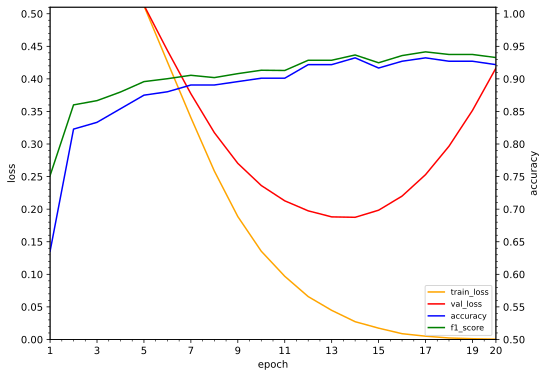

In [24]:
if __name__ == "__main__":

    epochs = 20
    marker = Marker(workdir=os.getcwd()+"/trainlog/", epochs=epochs,
                    columns=['train_loss', 'val_loss', 'accuracy', 'precision', 'recall', 'f1_score', 'pre_time', 'train_time', 'aft_time'], 
                    model='LiHuNet', optim='Lion', dataset='test', num_workers=num_workers, batch_size=batch_size,
                    embedding_model = embedding_model, embedding_size=embedding_size, learning_rate=lr, weight_decay=wd)

    controller = Controller()
    controller.register('stdSTART', marker.stdSTART, **figure_args)
    controller.register('stdIO', MyIO, 
                        marker=marker, device_name=device_name, env_info=env_info, **figure_args)

    train(device=device, marker=marker, controller=controller, model=model, optimizer=optimizer, Loss=F.binary_cross_entropy, 
                train_loader=train_loader, val_loader=val_loader, epochs=epochs)
    
    controller.register('stdEND', marker.stdEND, 
                        device_name=device_name, env_info=env_info, **figure_args)
    controller.run(MyEND(marker=marker, **figure_args))